In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from preprocessing import read_img

In [242]:
data = pd.read_csv("dataset/HAM10000_metadata.csv")

In [243]:
target_size = 1000
balanced_data = data.groupby('dx', group_keys=False).apply(
    lambda x: x.sample(n=target_size, replace=True, random_state=42)
).reset_index(drop=True)

/var/folders/yz/bms59l5j5cl16ztb19ty54s40000gn/T/ipykernel_86348/2683717389.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = data.groupby('dx', group_keys=False).apply(


In [244]:
balanced_data, test_data = train_test_split(balanced_data, test_size=0.3, random_state=42)


In [237]:
balanced_data['image_id'] = balanced_data['image_id'].apply(lambda x: x + '.jpg')


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

train_generator = datagen.flow_from_dataframe(
    dataframe=balanced_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=balanced_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, mode='min', restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

model.save('cnn_model.h5', save_format='h5')

Found 3920 validated image filenames belonging to 7 classes.


Found 980 validated image filenames belonging to 7 classes.
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - accuracy: 0.1891 - loss: 1.9045 - precision: 0.3655 - val_accuracy: 0.3735 - val_loss: 1.5692 - val_precision: 0.8699
Epoch 2/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.3588 - loss: 1.5744 - precision: 0.7481 - val_accuracy: 0.3949 - val_loss: 1.4509 - val_precision: 0.7225
Epoch 3/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.4068 - loss: 1.4642 - precision: 0.7208 - val_accuracy: 0.4612 - val_loss: 1.3688 - val_precision: 0.8389
Epoch 4/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.4151 - loss: 1.4295 - precision: 0.7811 - val_accuracy: 0.4827 - val_loss: 1.3470 - val_precision: 0.8304
Epoch 5/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.4490 - loss: 1.3741 - precision: 0.7834 - val_accuracy: 0.4714 - val_loss: 1.3264 - val_precision: 0.7925
Epoch 6/30
123/123 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - accuracy: 0.4559 - loss: 1.3650 - precision: 0.8013 - val_accuracy: 0.4939 - va

In [238]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Training samples: 3920
Validation samples: 980


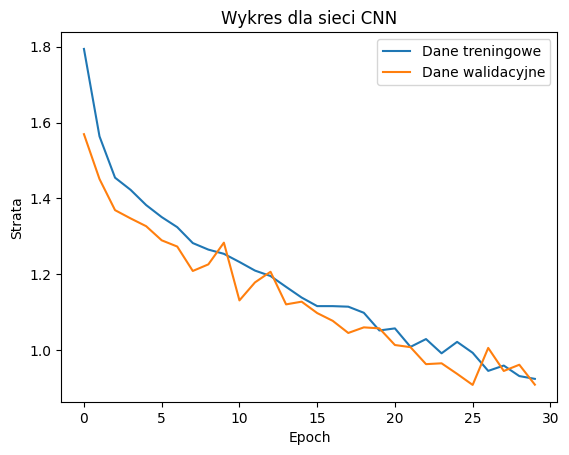

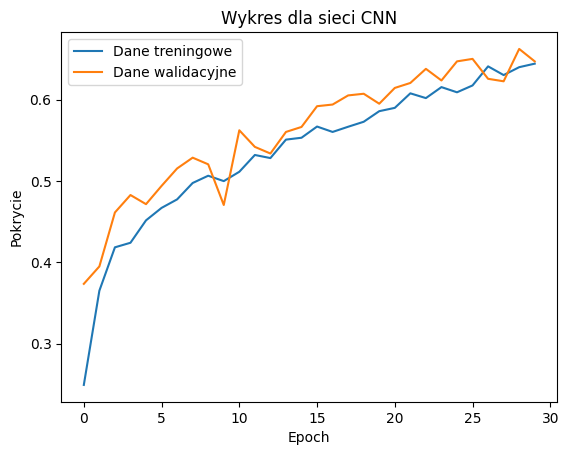

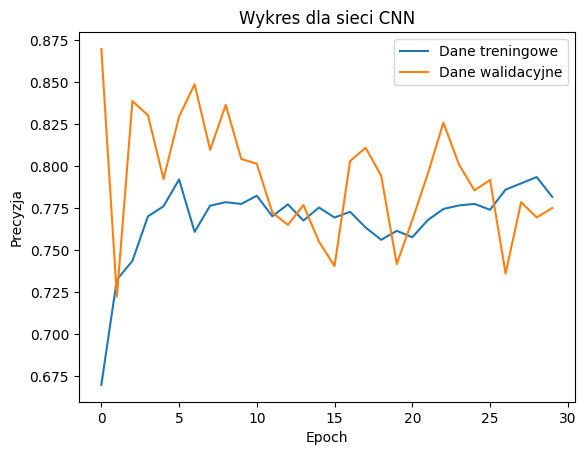

In [239]:
metrics = ['loss', 'accuracy', 'precision']
metryki = ['Strata', 'Pokrycie', "Precyzja"]
i = 0
for metric in metrics:
    plt.plot(history.history[metric], label='Dane treningowe')
    plt.plot(history.history[f'val_{metric}'], label='Dane walidacyjne')
    plt.xlabel('Epoch')
    plt.ylabel(metryki[i])
    plt.legend(loc='best')
    plt.title("Wykres dla sieci CNN")
    plt.show()
    i += 1

In [101]:
model = load_model('cnn_model.h5')

In [102]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,545 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [104]:
test_data

,lesion_id,image_id,dx,dx_type,age,sex,localization
6500,HAM_0001852,ISIC_0034196,vasc,histo,80.0,male,lower extremity
2944,HAM_0000607,ISIC_0025431,bkl,consensus,45.0,female,abdomen
2024,HAM_0001487,ISIC_0031601,bkl,consensus,60.0,male,neck
263,HAM_0000769,ISIC_0029851,akiec,histo,80.0,male,lower extremity
4350,HAM_0000513,ISIC_0032207,mel,histo,35.0,female,upper extremity
...,...,...,...,...,...,...,...
5945,HAM_0006512,ISIC_0027614,nv,histo,35.0,female,back
1630,HAM_0005184,ISIC_0029644,bcc,histo,40.0,female,lower extremity
4043,HAM_0001847,ISIC_0024792,mel,histo,50.0,male,back
1881,HAM_0001654,ISIC_0024472,bcc,histo,85.0,male,lower extremity


In [105]:
test_data['image_id'] = test_data['image_id'].apply(lambda x: x + '.jpg')

In [106]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 2100 validated image filenames belonging to 7 classes.


In [107]:
y_pred_probs = model.predict(test_generator) 
y_pred = np.argmax(y_pred_probs, axis=1)    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step


In [108]:
y_true = test_generator.classes 

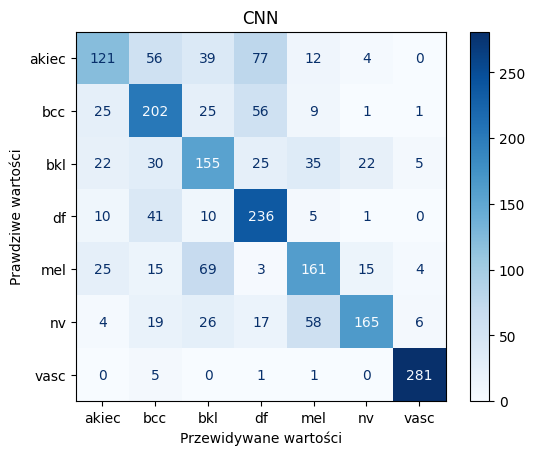

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)

plt.xlabel("Przewidywane wartości")
plt.ylabel("Prawdziwe wartości")
plt.title("CNN")
plt.show()

In [118]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       akiec       0.58      0.39      0.47       309
         bcc       0.55      0.63      0.59       319
         bkl       0.48      0.53      0.50       294
          df       0.57      0.78      0.66       303
         mel       0.57      0.55      0.56       292
          nv       0.79      0.56      0.66       295
        vasc       0.95      0.98      0.96       288

    accuracy                           0.63      2100
   macro avg       0.64      0.63      0.63      2100
weighted avg       0.64      0.63      0.63      2100



# Unbalanced dataset

In [ ]:
data = pd.read_csv("dataset/HAM10000_metadata.csv")

In [127]:
data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [119]:
data['image_id'] = data['image_id'].apply(lambda x: x + '.jpg')


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,  
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

train_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, mode='min', restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

model.save('cnn_model_unbalanced.h5', save_format='h5')

Found 7011 validated image filenames belonging to 7 classes.
Found 3004 validated image filenames belonging to 7 classes.
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 30s 131ms/step - accuracy: 0.9242 - loss: 0.3171 - precision: 0.9460 - val_accuracy: 0.0100 - val_loss: 15.5164 - val_precision: 0.0100
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 130ms/step - accuracy: 0.9514 - loss: 0.1795 - precision: 0.9516 - val_accuracy: 0.0100 - val_loss: 9.5633 - val_precision: 0.0100
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - accuracy: 0.9471 - loss: 0.1696 - precision: 0.9475 - val_accuracy: 0.0100 - val_loss: 7.6307 - val_precision: 0.0100
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - accuracy: 0.9507 - loss: 0.1597 - precision: 0.9507 - val_accuracy: 0.0100 - val_loss: 9.0597 - val_precision: 0.0100
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.9537 - loss: 0.1561 - precision: 0.9537 - val_accuracy: 0.0100 - val_loss: 11.1124 - val_precision: 0.0100
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 29s 131ms/step - accuracy: 0.9527 - loss: 0.1506 - precision: 0.9528 - val_accuracy: 0.0100 - 

In [120]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Training samples: 7011
Validation samples: 3004


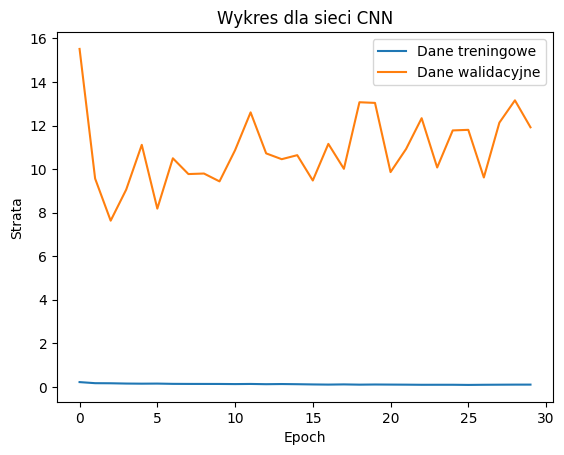

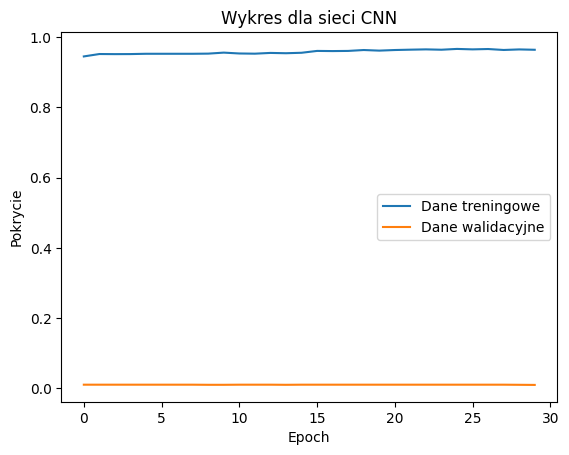

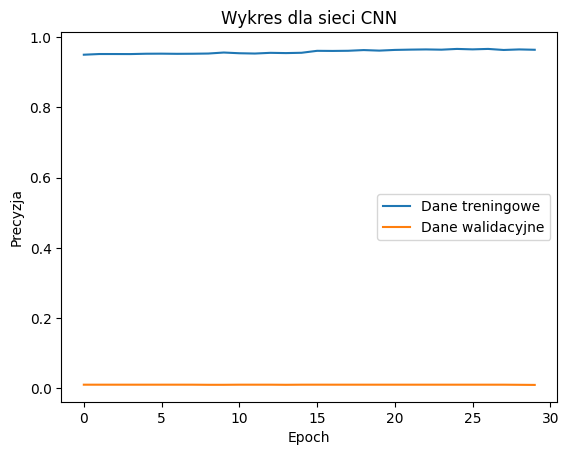

In [121]:
metrics = ['loss', 'accuracy', 'precision']
metryki = ['Strata', 'Pokrycie', "Precyzja"]
i = 0
for metric in metrics:
    plt.plot(history.history[metric], label='Dane treningowe')
    plt.plot(history.history[f'val_{metric}'], label='Dane walidacyjne')
    plt.xlabel('Epoch')
    plt.ylabel(metryki[i])
    plt.legend(loc='best')
    plt.title("Wykres dla sieci CNN")
    plt.show()
    i += 1

In [128]:
test_data['image_id']

1617    ISIC_0033272.jpg
8128    ISIC_0031923.jpg
2168    ISIC_0026652.jpg
1090    ISIC_0030583.jpg
7754    ISIC_0034010.jpg
              ...       
4635    ISIC_0032121.jpg
8386    ISIC_0028706.jpg
3707    ISIC_0028102.jpg
1839    ISIC_0033055.jpg
1995    ISIC_0030970.jpg
Name: image_id, Length: 3005, dtype: object

In [129]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='dx',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)
y_pred_probs = model.predict(test_generator) 
y_pred = np.argmax(y_pred_probs, axis=1)    
y_true = test_generator.classes  

Found 3005 validated image filenames belonging to 7 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step


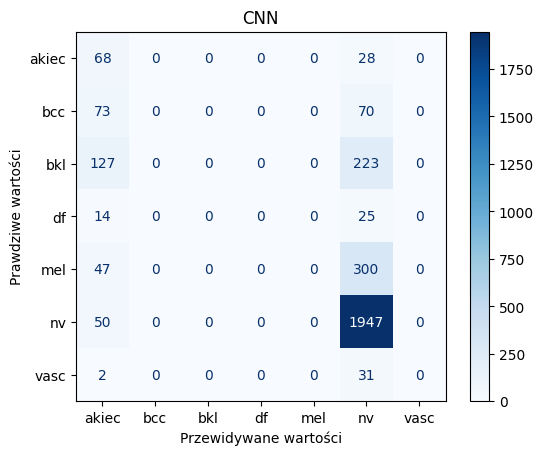

In [130]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)

plt.xlabel("Przewidywane wartości")
plt.ylabel("Prawdziwe wartości")
plt.title("CNN")
plt.show()

In [131]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

       akiec       0.18      0.71      0.29        96
         bcc       0.00      0.00      0.00       143
         bkl       0.00      0.00      0.00       350
          df       0.00      0.00      0.00        39
         mel       0.00      0.00      0.00       347
          nv       0.74      0.97      0.84      1997
        vasc       0.00      0.00      0.00        33

    accuracy                           0.67      3005
   macro avg       0.13      0.24      0.16      3005
weighted avg       0.50      0.67      0.57      3005



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# Binary

Unbalanced

In [136]:
df = pd.read_csv("dataset/HAM10000_metadata.csv")

In [137]:
df_binary = df.copy()

In [139]:
df_binary['binary_disease'] = df_binary['dx'].apply(lambda x: 'mel' if x == 'mel' else 'non-mel')

In [140]:
data, test_data = train_test_split(df_binary, test_size=0.3, random_state=42)

In [141]:
data['image_id'] = data['image_id'].apply(lambda x: x + '.jpg')


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,  
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

train_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, mode='min', restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

model.save('cnn_model_unbalanced_bi.h5', save_format='h5')

Found 4907 validated image filenames belonging to 2 classes.
Found 2103 validated image filenames belonging to 2 classes.
Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.8838 - loss: 0.3691 - precision: 0.8838 - val_accuracy: 0.8845 - val_loss: 0.3354 - val_precision: 0.8845
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.8925 - loss: 0.3300 - precision: 0.8925 - val_accuracy: 0.8845 - val_loss: 0.3216 - val_precision: 0.8845
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - accuracy: 0.8869 - loss: 0.3303 - precision: 0.8869 - val_accuracy: 0.8845 - val_loss: 0.3940 - val_precision: 0.8845
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.8882 - loss: 0.3266 - precision: 0.8882 - val_accuracy: 0.8849 - val_loss: 0.3144 - val_precision: 0.8849
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.9002 - loss: 0.2946 - precision: 0.9002 - val_accuracy: 0.8849 - val_loss: 0.3071 - val_precision: 0.8849
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - accuracy: 0.8965 - loss: 0.2939 - precision: 0.8965 - val_accuracy: 0.8849 - va

In [142]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,914,696 (37.82 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,609,798 (25.21 MB)

In [143]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Training samples: 4907
Validation samples: 2103


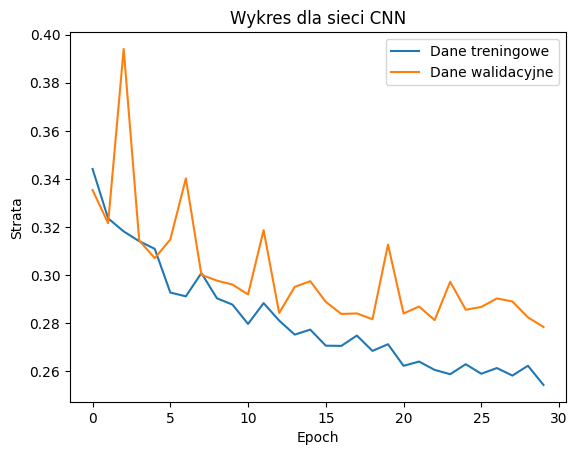

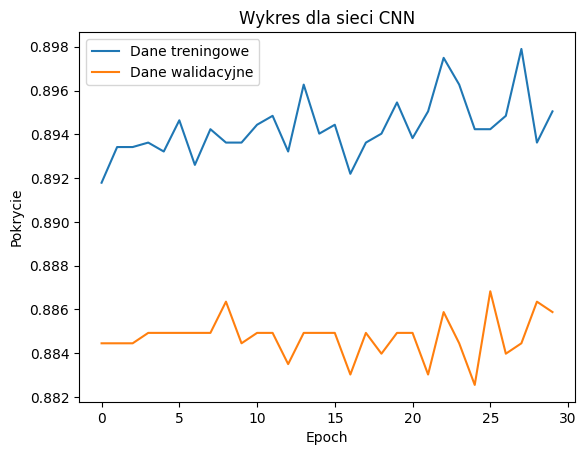

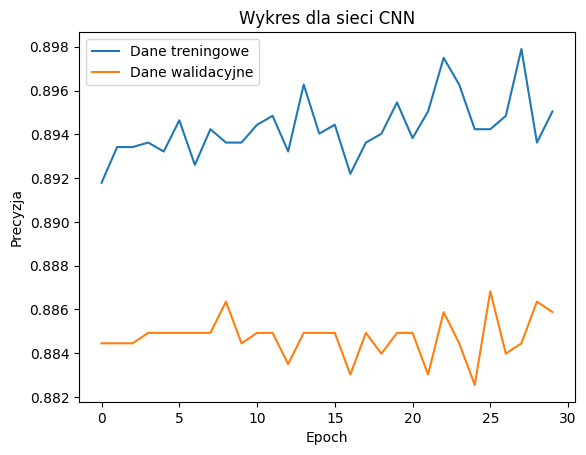

In [144]:
metrics = ['loss', 'accuracy', 'precision']
metryki = ['Strata', 'Pokrycie', "Precyzja"]
i = 0
for metric in metrics:
    plt.plot(history.history[metric], label='Dane treningowe')
    plt.plot(history.history[f'val_{metric}'], label='Dane walidacyjne')
    plt.xlabel('Epoch')
    plt.ylabel(metryki[i])
    plt.legend(loc='best')
    plt.title("Wykres dla sieci CNN")
    plt.show()
    i += 1

In [145]:
test_data['image_id'] = test_data['image_id'].apply(lambda x: x + '.jpg')
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)
y_pred_probs = model.predict(test_generator) 
y_pred = np.argmax(y_pred_probs, axis=1)    
y_true = test_generator.classes  

Found 3005 validated image filenames belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step


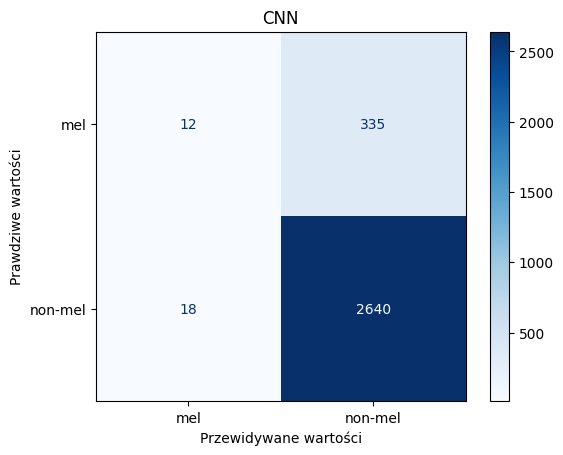

In [146]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)

plt.xlabel("Przewidywane wartości")
plt.ylabel("Prawdziwe wartości")
plt.title("CNN")
plt.show()

In [147]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

         mel       0.40      0.03      0.06       347
     non-mel       0.89      0.99      0.94      2658

    accuracy                           0.88      3005
   macro avg       0.64      0.51      0.50      3005
weighted avg       0.83      0.88      0.84      3005



Balanced

In [149]:
df = pd.read_csv("dataset/HAM10000_metadata.csv")
df_binary = df.copy()
df_binary['binary_disease'] = df_binary['dx'].apply(lambda x: 'mel' if x == 'mel' else 'non-mel')
target_size = 1000
balanced_data = df_binary.groupby('binary_disease', group_keys=False).apply(
    lambda x: x.sample(n=target_size, replace=True, random_state=42)
).reset_index(drop=True)

/var/folders/yz/bms59l5j5cl16ztb19ty54s40000gn/T/ipykernel_86348/1451520059.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = df_binary.groupby('binary_disease', group_keys=False).apply(


In [150]:
balanced_data, test_data = train_test_split(balanced_data, test_size=0.3, random_state=42)

In [152]:
balanced_data['image_id'] = balanced_data['image_id'].apply(lambda x: x + '.jpg')


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,  
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

train_generator = datagen.flow_from_dataframe(
    dataframe=balanced_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'  
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=balanced_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'precision'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, mode='min', restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

model.save('cnn_model_balanced_bi.h5', save_format='h5')

Found 980 validated image filenames belonging to 2 classes.
Found 420 validated image filenames belonging to 2 classes.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.5741 - loss: 0.7024 - precision: 0.5741 - val_accuracy: 0.6714 - val_loss: 0.6373 - val_precision: 0.6714
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6399 - loss: 0.6207 - precision: 0.6399 - val_accuracy: 0.5976 - val_loss: 0.6689 - val_precision: 0.5976
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6213 - loss: 0.6425 - precision: 0.6213 - val_accuracy: 0.6333 - val_loss: 0.6199 - val_precision: 0.6333
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.6615 - loss: 0.6017 - precision: 0.6615 - val_accuracy: 0.6476 - val_loss: 0.6338 - val_precision: 0.6476
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.6459 - loss: 0.6189 - precision: 0.6459 - val_accuracy: 0.6690 - val_loss: 0.5905 - val_precision: 0.6690
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.6656 - loss: 0.5872 - precision: 0.6656 - val_accuracy: 0.6762 - val_loss:

In [153]:
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Training samples: 980
Validation samples: 420


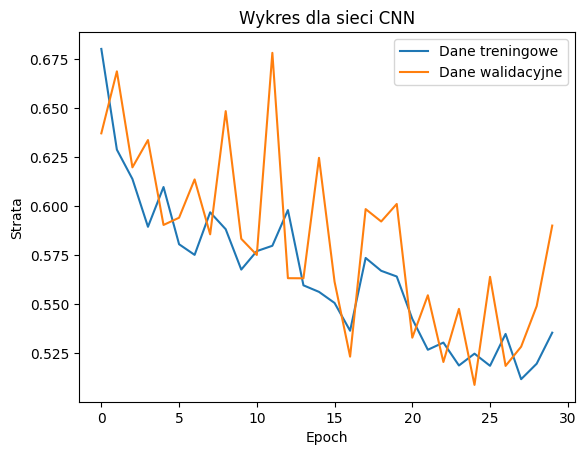

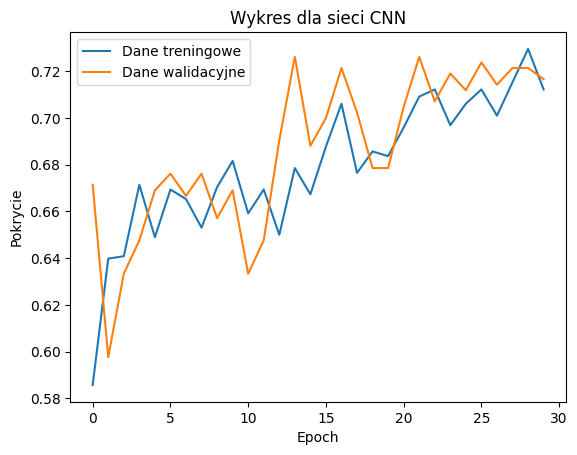

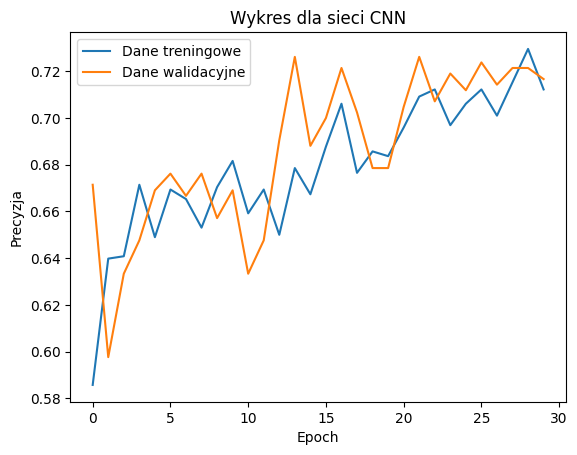

In [154]:
metrics = ['loss', 'accuracy', 'precision']
metryki = ['Strata', 'Pokrycie', "Precyzja"]
i = 0
for metric in metrics:
    plt.plot(history.history[metric], label='Dane treningowe')
    plt.plot(history.history[f'val_{metric}'], label='Dane walidacyjne')
    plt.xlabel('Epoch')
    plt.ylabel(metryki[i])
    plt.legend(loc='best')
    plt.title("Wykres dla sieci CNN")
    plt.show()
    i += 1

In [155]:
test_data['image_id'] = test_data['image_id'].apply(lambda x: x + '.jpg')

In [156]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/Users/htlusty/Documents/DYPLOMA/dataset/data_with_mask_otsu',
    x_col='image_id',
    y_col='binary_disease',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)

Found 600 validated image filenames belonging to 2 classes.


In [157]:
y_pred_probs = model.predict(test_generator) 
y_pred = np.argmax(y_pred_probs, axis=1)  
y_true = test_generator.classes   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


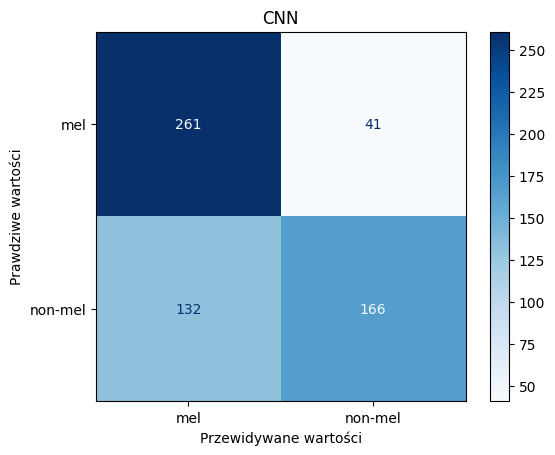

In [158]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)

plt.xlabel("Przewidywane wartości")
plt.ylabel("Prawdziwe wartości")
plt.title("CNN")
plt.show()

In [159]:
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

         mel       0.66      0.86      0.75       302
     non-mel       0.80      0.56      0.66       298

    accuracy                           0.71       600
   macro avg       0.73      0.71      0.70       600
weighted avg       0.73      0.71      0.70       600



# Augmentation

In [246]:
balanced_data['image_id'] = balanced_data['image_id'].apply(lambda x: x + '.jpg')

In [248]:
balanced_data

,lesion_id,image_id,dx,dx_type,age,sex,localization
1612,HAM_0004420,ISIC_0024795.jpg,bcc,histo,55.0,male,back
978,HAM_0000931,ISIC_0028820.jpg,akiec,histo,80.0,male,lower extremity
3050,HAM_0006542,ISIC_0030015.jpg,df,consensus,65.0,male,upper extremity
4960,HAM_0000002,ISIC_0034246.jpg,mel,histo,65.0,female,lower extremity
2548,HAM_0002306,ISIC_0027606.jpg,bkl,histo,65.0,male,upper extremity
...,...,...,...,...,...,...,...
3772,HAM_0004330,ISIC_0029760.jpg,df,histo,70.0,male,lower extremity
5191,HAM_0005033,ISIC_0032224.jpg,nv,follow_up,45.0,female,trunk
5226,HAM_0005963,ISIC_0028129.jpg,nv,follow_up,45.0,male,foot
5390,HAM_0003828,ISIC_0031657.jpg,nv,histo,35.0,female,abdomen


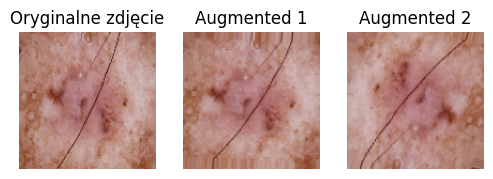

In [261]:
original_image = image.load_img('./dataset/data_with_mask_otsu/{}'.format(balanced_data['image_id'].iloc[0]), target_size=(128, 128))
original_image = image.img_to_array(original_image) /255 

aug_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.3,
    shear_range=0.2,
    fill_mode='nearest',
)

augmented_images = aug_datagen.flow(np.expand_dims(original_image, axis=0), batch_size=1)

fig, axes = plt.subplots(1, 3, figsize=(6, 3))

axes[0].imshow(original_image)
axes[0].set_title("Oryginalne zdjęcie")
axes[0].axis('off')

for i in range(1, 3):
    aug_img = next(augmented_images)[0]  
    axes[i].imshow(aug_img)
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

plt.show()


In [262]:
next(augmented_images)[0]

array([[[0.64685476, 0.42724693, 0.3502588 ],
        [0.6545282 , 0.43492034, 0.35281658],
        [0.66220164, 0.44259378, 0.3553744 ],
        ...,
        [0.6350766 , 0.43899813, 0.34790492],
        [0.62022865, 0.40970543, 0.31589818],
        [0.67209905, 0.47158244, 0.3662167 ]],

       [[0.6402382 , 0.42949605, 0.36947864],
        [0.6368278 , 0.42267522, 0.36010003],
        [0.6334174 , 0.4158544 , 0.3507214 ],
        ...,
        [0.6267077 , 0.4291426 , 0.3385749 ],
        [0.62674564, 0.41651043, 0.32086328],
        [0.6706217 , 0.47321376, 0.37445965]],

       [[0.664911  , 0.4609894 , 0.40831894],
        [0.6580901 , 0.45416856, 0.4006455 ],
        [0.6512693 , 0.44734773, 0.39297208],
        ...,
        [0.62506723, 0.42422128, 0.33283332],
        [0.6382287 , 0.4304542 , 0.33234638],
        [0.6657004 , 0.47157332, 0.38184166]],

       ...,

       [[0.55788535, 0.3597805 , 0.26367393],
        [0.5998628 , 0.3632386 , 0.25728762],
        [0.591465  , 0